In [46]:
import pandas as pd
import geopandas as gpd
import os
from shapely.geometry import shape
import numpy as np
import glob
from collections import OrderedDict
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [27]:
dir="//smb.isipd.dmawi.de/projects/sparc/personal_accounts/Mehriban/expedition2024/ibuttons23_kamik/"

In [30]:
csv_files = glob.glob(os.path.join(dir, "*24.csv"))

temp = {}


for file in csv_files:
 
    file_name = os.path.basename(file)[2:5]
    
    
    df = pd.read_csv(file, skiprows=19, delimiter=',')
    
   
    temp[file_name] = df

temp

{'538':                 Date/Time Unit   Value
 0     7/31/23 11:59:45 PM    C  21.938
 1      8/1/23 12:59:45 AM    C  22.750
 2       8/1/23 1:59:45 AM    C  21.375
 3       8/1/23 2:59:45 AM    C  21.312
 4       8/1/23 3:59:45 AM    C  21.000
 ...                   ...  ...     ...
 9216  8/18/24 11:59:45 PM    C  23.875
 9217  8/19/24 12:59:45 AM    C  24.562
 9218   8/19/24 1:59:45 AM    C  25.000
 9219   8/19/24 2:59:45 AM    C  25.312
 9220   8/19/24 3:59:45 AM    C  26.250
 
 [9221 rows x 3 columns],
 '539':                 Date/Time Unit   Value
 0      8/1/23 12:00:08 AM    C  22.125
 1       8/1/23 1:00:08 AM    C  22.000
 2       8/1/23 2:00:08 AM    C  21.500
 3       8/1/23 3:00:08 AM    C  21.438
 4       8/1/23 4:00:08 AM    C  21.312
 ...                   ...  ...     ...
 9216  8/19/24 12:00:08 AM    C  23.938
 9217   8/19/24 1:00:08 AM    C  24.562
 9218   8/19/24 2:00:08 AM    C  25.000
 9219   8/19/24 3:00:08 AM    C  25.375
 9220   8/19/24 4:00:08 AM    C  32.31

In [37]:
coordinates = pd.read_csv(dir + 'ibuttons_WGS_coordinates.csv')

coordinates['file_id'] = coordinates['ID'].str[-3:] 
coordinates['file_path'] = coordinates['file_id'].map(lambda x: temp.get(x))
coordinates_sorted = coordinates.sort_values(by=['X', 'Y'])


In [44]:
ordered_dataframes = []


ordered_dataframes = OrderedDict()

for file_id in coordinates_sorted['file_id']:
    if file_id in temp:
        ordered_dataframes[file_id] = temp[file_id]  
    else:
        ordered_dataframes[file_id] = None  

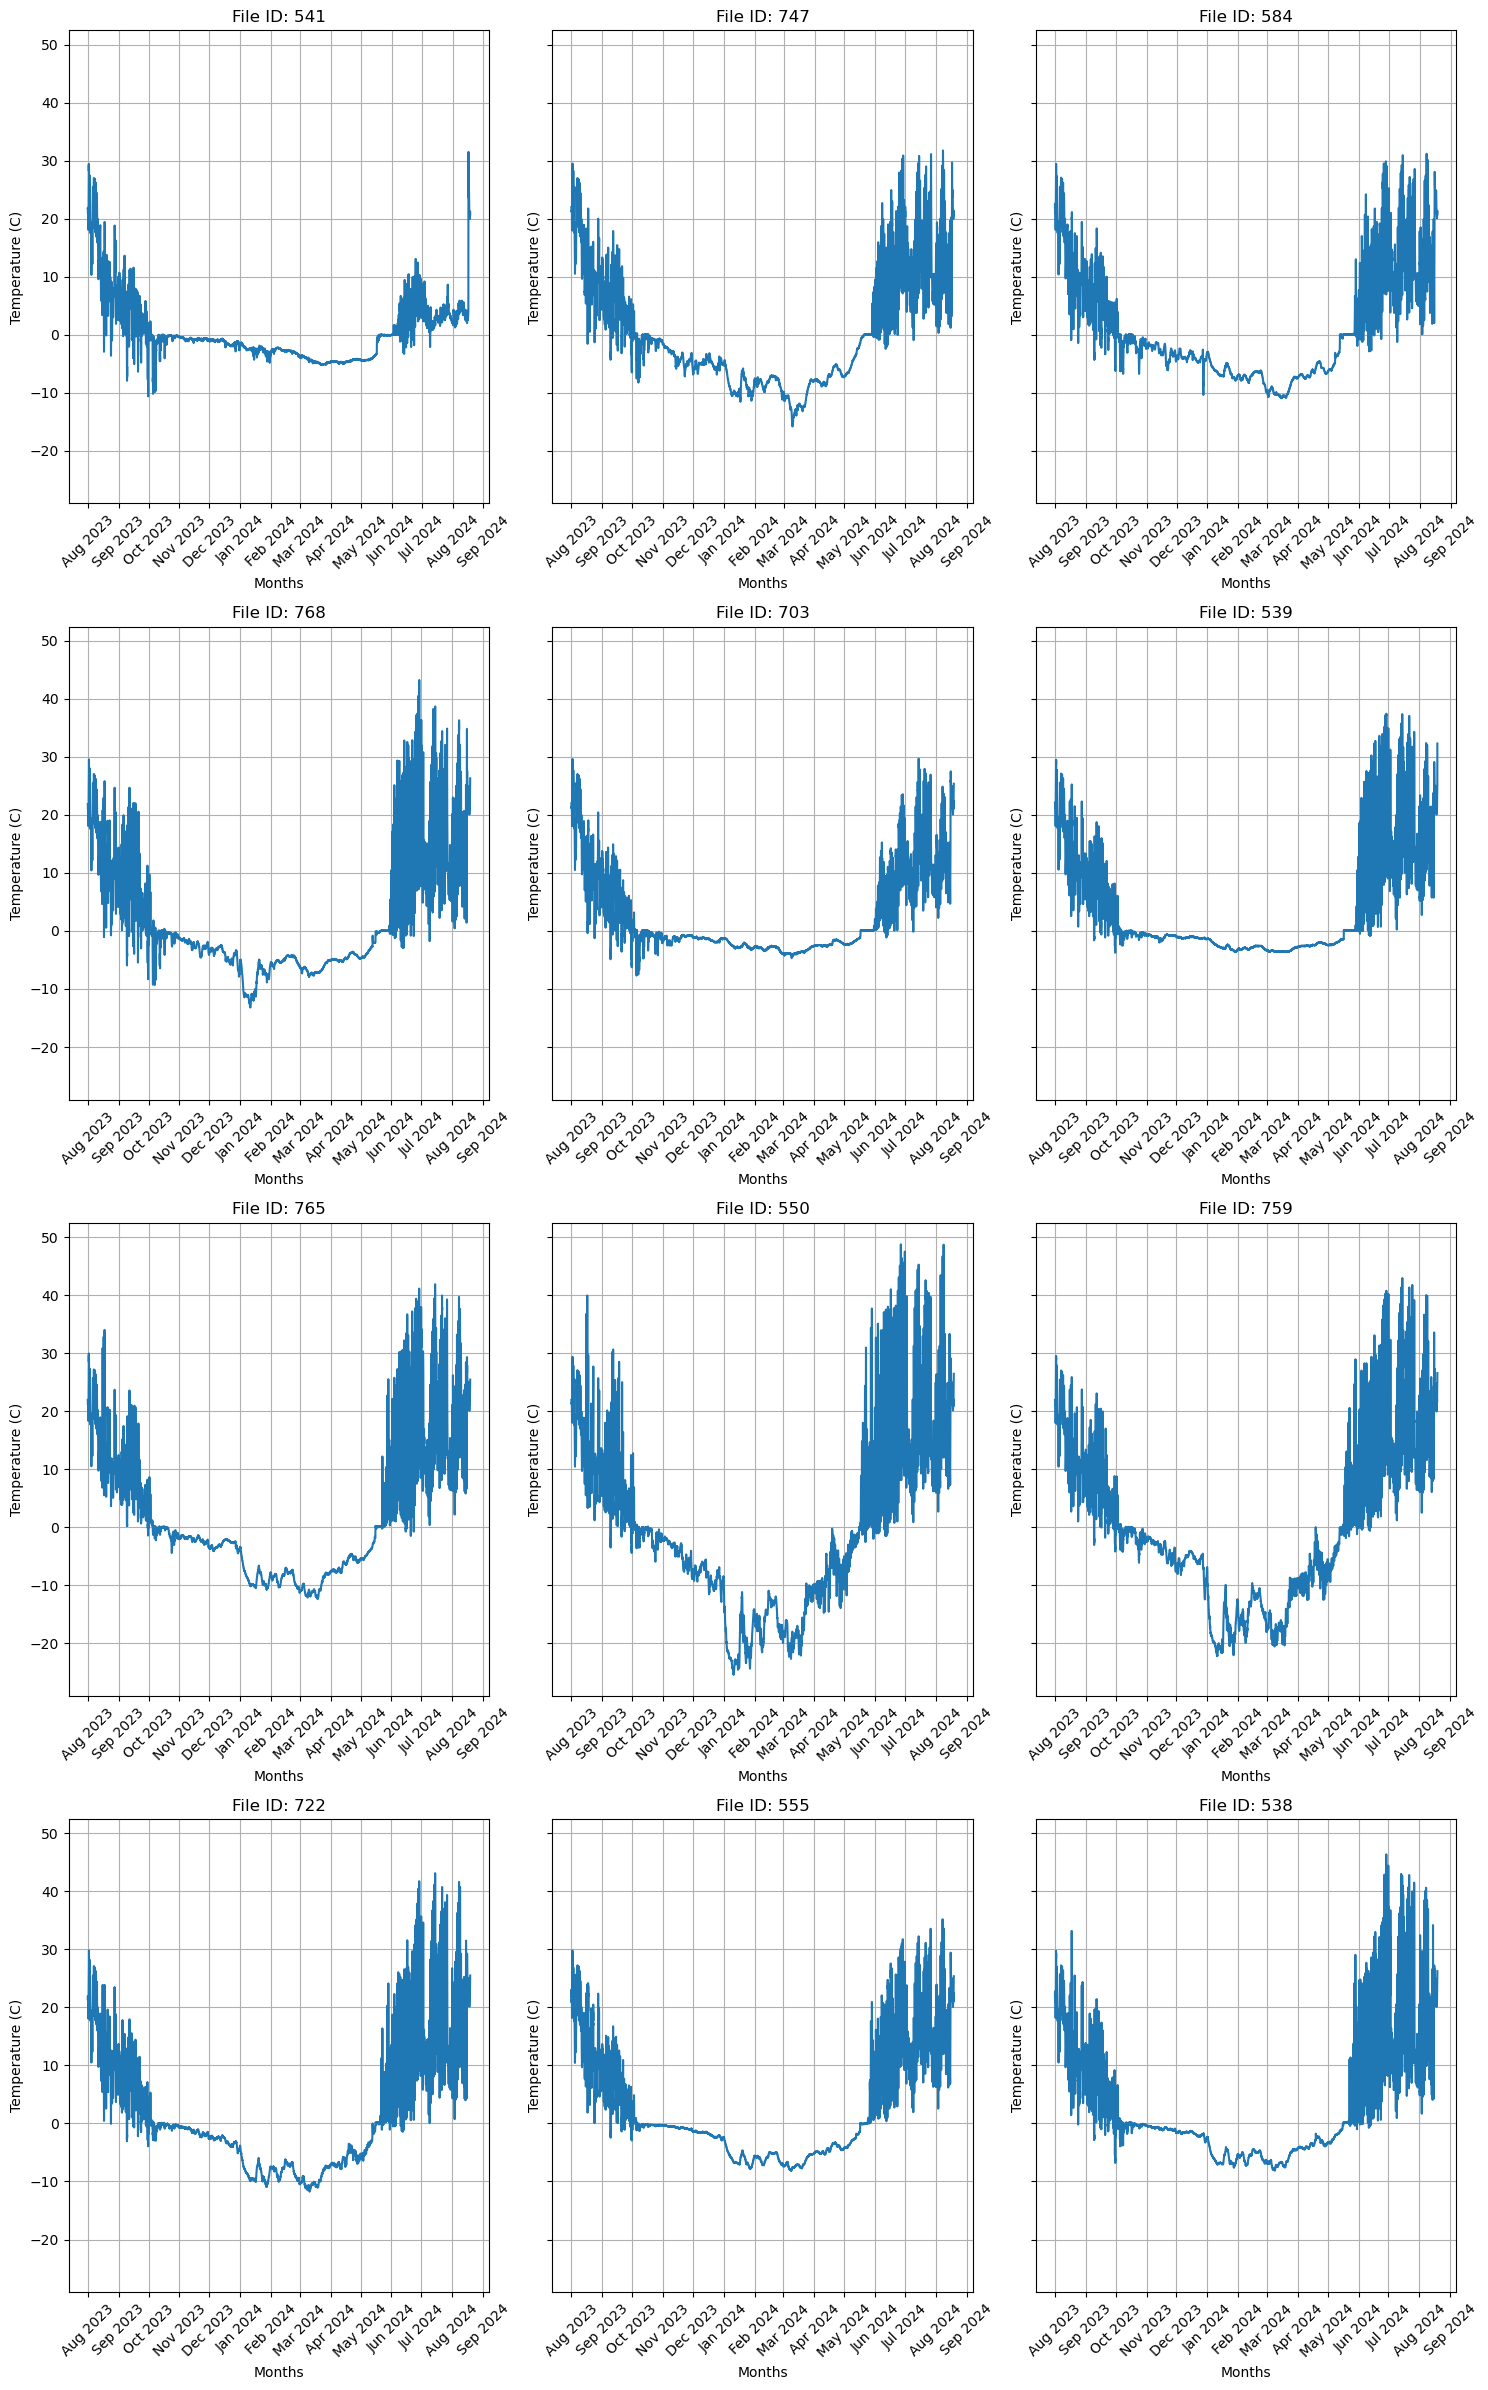

In [51]:

num_dfs = len(ordered_dataframes)
cols = 3  
rows = (num_dfs + 1) // cols  

fig, axs = plt.subplots(rows, cols, figsize=(15, 6 * rows), sharey=True)

axs = axs.ravel()  

for i, (file_id, df) in enumerate(ordered_dataframes.items()):
    if df is not None and df.shape[1] >= 3:  
        # Convert the first column to datetime
        df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0], format='%m/%d/%y %I:%M:%S %p')
        
        axs[i].plot(df.iloc[:, 0], df.iloc[:, 2])  
        axs[i].set_title(f'File ID: {file_id}')
        
        # Set x-axis to display months with fewer labels
        axs[i].xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Show every 2 months
        axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format as "Month Year"
        
        axs[i].set_xlabel('Months')  
        axs[i].set_ylabel('Temperature (C)')
        axs[i].grid()  
        plt.setp(axs[i].xaxis.get_majorticklabels(), rotation=45)  # Rotate date labels for better readability
    else:
        axs[i].set_title(f'File ID: {file_id} - No Data')
        axs[i].set_visible(False)  

# Adjust layout
plt.tight_layout()
plt.show()


Degree days

In [91]:
results = {}

# Define your date range
start_date = '2023-08-10'
end_date = '2024-08-10'

for i, (file_id, df) in enumerate(ordered_dataframes.items()):
    if df is not None and df.shape[1] >= 3:
        # Convert the first column to datetime
        df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0], format='%m/%d/%y %I:%M:%S %p')
        
        # Set the datetime column as the index
        df.set_index(df.iloc[:, 0], inplace=True)
        
        # Slice the DataFrame to the desired date range
        df = df.loc[start_date:end_date]
        
        # Resample the temperature column (assuming it's the 3rd column) to daily mean
        daily_mean = df.iloc[:, 2].resample('D').mean().reset_index()

        daily_mean['FDD'] = (daily_mean.iloc[:, 1] < 0) * (-daily_mean.iloc[:, 1])  # Change to iloc[:, 1]
        total_fdd = daily_mean['FDD'].sum()

    # Calculate Thawing Degree Days (TDD)
        daily_mean['TDD'] = (daily_mean.iloc[:, 1] > 0) * daily_mean.iloc[:, 1]  # Change to iloc[:, 1]
        total_tdd = daily_mean['TDD'].sum()

        # Store results
        results[file_id] = {'Total FDD Days': total_fdd, 'Total TDD Days': total_tdd}

# Print results for all files
for file_id, result in results.items():
    print(f"File {file_id}: Freezing Degree Days = {result['Total FDD Days']}, Thawing Degree Days = {result['Total TDD Days']}")

results  
        

c:\Users\mealiy001\AppData\Local\anaconda3\envs\pgcore\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)
c:\Users\mealiy001\AppData\Local\anaconda3\envs\pgcore\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)
c:\Users\mealiy001\AppData\Local\anaconda3\envs\pgcore\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in 

File 541: Freezing Degree Days = 609.96725, Thawing Degree Days = 546.5027083333333
File 747: Freezing Degree Days = 1467.4157083333334, Thawing Degree Days = 1253.5523749999998
File 584: Freezing Degree Days = 1203.6627916666666, Thawing Degree Days = 1240.705
File 768: Freezing Degree Days = 1048.4675416666666, Thawing Degree Days = 1418.2540416666666
File 703: Freezing Degree Days = 488.67875000000004, Thawing Degree Days = 1141.4630833333333
File 539: Freezing Degree Days = 456.31012499999997, Thawing Degree Days = 1496.8972916666667
File 765: Freezing Degree Days = 1275.826625, Thawing Degree Days = 1645.9700833333334
File 550: Freezing Degree Days = 2368.7707499999997, Thawing Degree Days = 1741.6162083333334
File 759: Freezing Degree Days = 2098.3933749999997, Thawing Degree Days = 1596.0370833333332
File 722: Freezing Degree Days = 1191.299625, Thawing Degree Days = 1481.5758333333333
File 555: Freezing Degree Days = 841.5644166666666, Thawing Degree Days = 1467.7964583333332
F

c:\Users\mealiy001\AppData\Local\anaconda3\envs\pgcore\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)
c:\Users\mealiy001\AppData\Local\anaconda3\envs\pgcore\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)
c:\Users\mealiy001\AppData\Local\anaconda3\envs\pgcore\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in 

{'541': {'Total FDD Days': 609.96725, 'Total TDD Days': 546.5027083333333},
 '747': {'Total FDD Days': 1467.4157083333334,
  'Total TDD Days': 1253.5523749999998},
 '584': {'Total FDD Days': 1203.6627916666666, 'Total TDD Days': 1240.705},
 '768': {'Total FDD Days': 1048.4675416666666,
  'Total TDD Days': 1418.2540416666666},
 '703': {'Total FDD Days': 488.67875000000004,
  'Total TDD Days': 1141.4630833333333},
 '539': {'Total FDD Days': 456.31012499999997,
  'Total TDD Days': 1496.8972916666667},
 '765': {'Total FDD Days': 1275.826625, 'Total TDD Days': 1645.9700833333334},
 '550': {'Total FDD Days': 2368.7707499999997,
  'Total TDD Days': 1741.6162083333334},
 '759': {'Total FDD Days': 2098.3933749999997,
  'Total TDD Days': 1596.0370833333332},
 '722': {'Total FDD Days': 1191.299625, 'Total TDD Days': 1481.5758333333333},
 '555': {'Total FDD Days': 841.5644166666666,
  'Total TDD Days': 1467.7964583333332},
 '538': {'Total FDD Days': 784.3567500000001,
  'Total TDD Days': 1537.5272

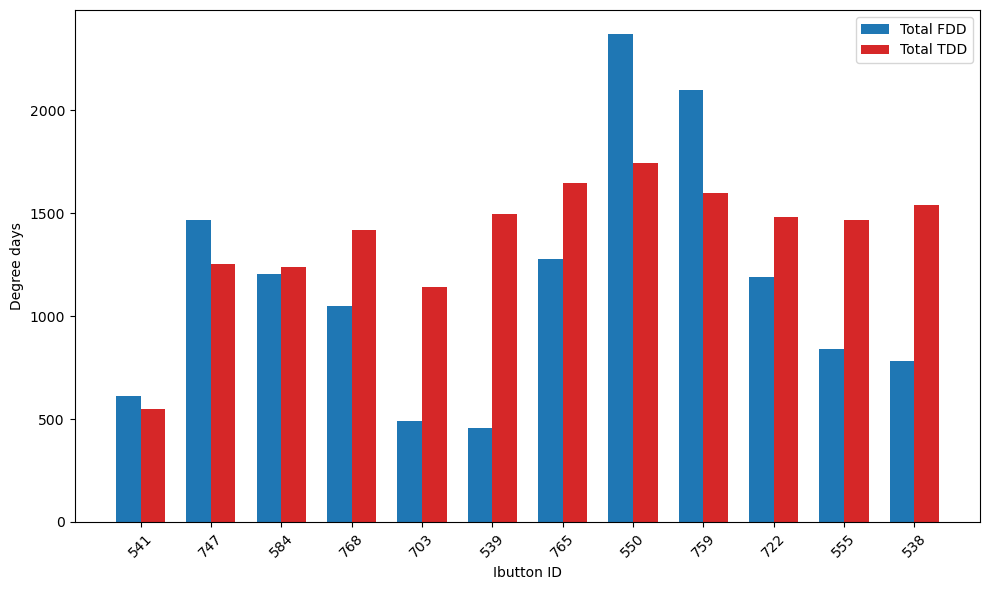

In [98]:
results_df = pd.DataFrame.from_dict(results, orient='index').reset_index()
results_df.columns = ['File ID', 'Total FDD', 'Total TDD']

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))  # Single plot

# Set bar width
bar_width = 0.35
x = np.arange(len(results_df['File ID']))

# Plotting both FDD and TDD
ax.bar(x - bar_width/2, results_df['Total FDD'], width=bar_width, label='Total FDD', color='tab:blue')
ax.bar(x + bar_width/2, results_df['Total TDD'], width=bar_width, label='Total TDD', color='tab:red')
#ax.bar(x + bar_width, results_df['Total FDD']/results_df['Total TDD'], width=bar_width, label='FDD/TDD', color='tab:green')

#ax.plot(x - bar_width/2, results_df['Total FDD']/367*100, color='tab:blue', marker='o', linewidth=1, label='FDD Fit Line')
#ax.plot(x + bar_width/2, results_df['Total TDD']/367*100, color='tab:red', marker='o', linewidth=1, label='TDD Fit Line')
#ax.plot(x + bar_width, results_df['Total FDD']/results_df['Total TDD']*100, color='tab:blue', marker='o', linewidth=1, label='FDD/TDD')

# Labels and title

ax.set_xlabel('Ibutton ID')
ax.set_ylabel('Degree days')
ax.set_xticks(x)
ax.set_xticklabels(results_df['File ID'], rotation=45)
ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()